In [13]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import simulation
import torch
import pyccl as ccl
from matplotlib.cm import get_cmap

In [14]:
where_data = '/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_data_vector/'
pinocchio_mock = np.load(where_data+'data_vector_pinocchio_mock_log_normal_poisson_scatter_sigma_lnMwl=0.00.pkl' , allow_pickle= True )

In [15]:
richness_bins = list(np.array(pinocchio_mock['richness_bins']).T[0])
richness_bins.append( np.array( pinocchio_mock['richness_bins'] ).T[1][-1]  )
redshift_bins = list(np.array( pinocchio_mock['redshift_bins']).T[0])
redshift_bins.append( np.array( pinocchio_mock['redshift_bins'] ).T[1][-1]  )

In [24]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )

stacked_simulator_pl.selection_richness = 0
def dOmega_z(z):
    return 0.25 * 4 * np.pi
stacked_simulator_pl.dOmega = dOmega_z
stacked_simulator_pl.richness_bins = richness_bins
stacked_simulator_pl.redshift_bins = redshift_bins
stacked_simulator_pl.sigma_mwl = 0#0.25
stacked_simulator_pl.include_mwl_measurement_errors = False
#stacked_simulator_pl.mwl_std = mwl_std
stacked_simulator_pl.correlation_mass_evolution = False
#stacked_simulator_pl.set_richness_mass_relation( 'power law' )
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.05 ) , 
                               log10m_bins=  np.arange( 14.2 , 15.5 , 0.05))
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
stacked_simulator_pl.hmf = ccl.halos.MassFuncDespali16(mass_def=massdef)

In [25]:
sim_obs = stacked_simulator_pl.run_simulation(torch.Tensor([ 0.30711 , 0.8288 , 0.6777 , 2.3 , 3.2, 0 , 0.5 ]))

0.3071100115776062 0.0480755342811088 0.6776999831199646 0.8288000226020813
89329 89329
3.200000047683716 0.0 2.299999952316284


In [26]:
sim_n_clusters = sim_obs[:25].reshape( len( pinocchio_mock['richness_bins'] ) , len( pinocchio_mock['richness_bins'] )  )
sim_mwl_mean = sim_obs[25:].reshape( len( pinocchio_mock['richness_bins'] ), len( pinocchio_mock['richness_bins'] ) )

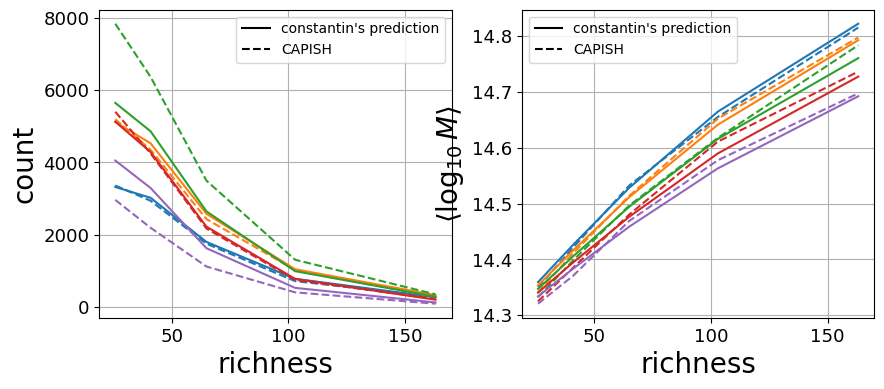

In [27]:
plt.figure( figsize = ( 10, 4 ))
plt.subplot(121)

for i in range( len( pinocchio_mock['mean_count_richness_redshift'] ) ):

    plt.plot( np.mean(pinocchio_mock['richness_bins'], axis=1) , 
              pinocchio_mock['mean_count_richness_redshift'][:,i] , '-'+'C'+str(i) )
    plt.plot( np.mean(pinocchio_mock['richness_bins'], axis=1) , sim_n_clusters.T[i] , '--'+'C'+str(i) )


#plt.xscale('log')
plt.plot([], [], '-k', label = "constantin's prediction")
plt.plot([], [], '--k', label = "CAPISH")
plt.xlabel('richness', fontsize=20,)
plt.ylabel('count', fontsize=20,)
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.grid()
plt.legend()

plt.subplot(122)

for i in range( len( pinocchio_mock['mean_count_richness_redshift'] ) ):

    plt.plot( np.mean(pinocchio_mock['richness_bins'], axis=1) , 
              pinocchio_mock['mean_log10mass_richness_redshift'][:,i] , '-'+'C'+str(i) )
    plt.plot( np.mean(pinocchio_mock['richness_bins'], axis=1) , sim_mwl_mean.T[i] , '--'+'C'+str(i) )


#plt.xscale('log')
plt.plot([], [], '-k', label = "constantin's prediction")
plt.plot([], [], '--k', label = "CAPISH")
plt.xlabel('richness', fontsize=20,)
plt.ylabel(r'$\langle \log_{10} M\rangle$', fontsize=20,)
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.grid()
plt.legend()